## Actions:
adding capabilities to the scalar Value Objects to enhance their role in the neural network

Second notebook [from lecture 1:](https://youtu.be/VMj-3S1tku0?t=5237)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
from graphviz import Digraph

In [3]:
def trace(root):
    # builds a set of all nodes and edges in a graph -- from a Value Object
    
    nodes, edges = set(), set()
    
    def build(v):
    # build reaches up out of scope to access nodes and edges... 
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                # recursive call to elaborate all of the child nodes 
                build(child)
    build(root)
    return nodes, edges


In [4]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        # each node displays label, data, and gradient at that leaf
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [5]:
class Value:
    # _children and _op at init requires values, used for history
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # gradient at each leaf/Value
        self.grad = 0 # initially set to 0 with the assumption that the leaf/Value
                      # does not effect the overall outcome (Loss Function)
            
        # backward as a attribute of the Value object
        # stores the gradient calculation at a given value (node)
        # by default None, depends on the operation and the children nodes
        self._backward = lambda: None
            
        # to capture the previous values and operations
        self._prev = set(_children)
        self._op = _op  # operation performed at the node
        self.label = label # name of the node
        
    def __repr__(self):
        # necessary to print out something readable -- otherwise shows
        # the function and location in memory
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # other must be a second Value object
        # pass children values to capture history
        out = Value(self.data + other.data, (self, other), '+')
        
        # closure to manage the backpropagation local to the operation
        def _backward():
            # addition propagates the gradient forward 
#            self.grad = 1.0 * out.grad
#            other.grad = 1.0 * out.grad
            # += is required if a Value object is used more than once, otherwise
            # the operation will over-write itself
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # an addition node has this function as the action for backpropagation
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 
        
        def _backward():
#            self.grad = out.grad * other.data
#            other.grad = out.grad * self.data
            # += is required if a Value object is used more than once, otherwise
            # the operation will over-write itself
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward    
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports ints and floats"
        out = Value(self.data ** other, (self,), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # use case other * self
        return self * other
    
    def __truediv__(self, other):  # for self/other
        return self * other**-1
    
    def __neg__(self): # - self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) *out.grad # local gradient chained to the prior gradient
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [6]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

In [7]:
# 
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

In [8]:
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [9]:
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [10]:
o.backward()

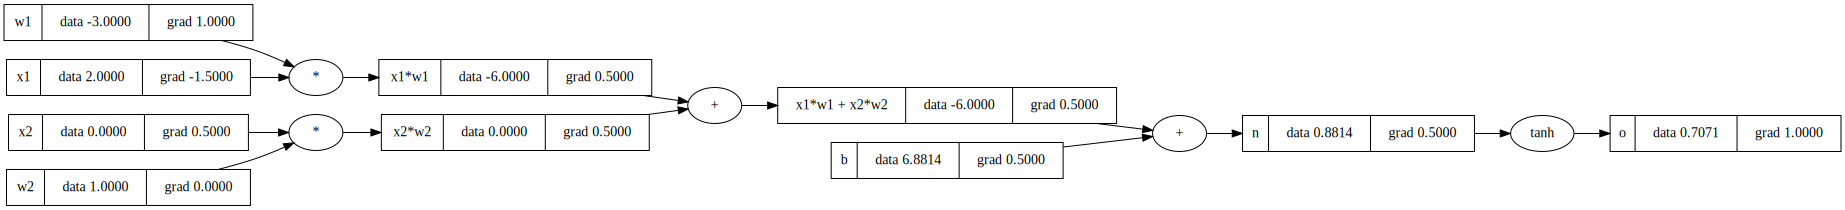

In [11]:
draw_dot(o)

In [12]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [13]:
b = Value(3.0)

In [14]:
a/b

Value(data=0.6666666666666666)

In [15]:
a -b

Value(data=-1.0)

In [16]:
# start https://youtu.be/VMj-3S1tku0?t=5798

In [17]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

In [18]:
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

In [19]:
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

In [20]:
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'

# expanded tanh term: 
e = (2*n).exp()
o = (e - 1)/(e + 1)

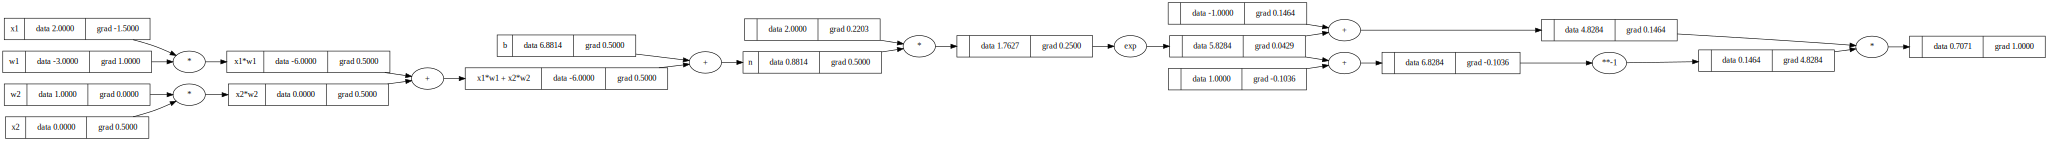

In [21]:
o.backward()
draw_dot(o)